In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import signal
import time
from tqdm import tqdm

In [2]:
class automaton():
    
    def __init__(self, init_state, num_iter, kernel, activ):
        self.state  = init_state    # nDimX x nDimY grid of 1s or 0s
        self.num_iter = num_iter
        self.nDimX  = np.asarray(self.state).shape[1]  # num cols
        self.nDimY  = np.asarray(self.state).shape[0]  # num rows  
        self.steady = False                            # we haven't reached steady state yet
        self.convState = np.empty_like(self.state)
        self.kernel = kernel                           # the "rules" of the cellular automaton!
        self.activ = activ
        
        # Creating the gaussian kernel for the gaussianKernel activation function!!
        gridX, gridY = np.meshgrid(np.linspace(-self.nDimX//2, self.nDimX//2, self.nDimX), np.linspace(-self.nDimY//2, self.nDimY//2, self.nDimY))
        self.grid = np.sqrt(gridX**2, gridY**2)
        assert self.grid.shape[0] == self.nDimX
        assert self.grid.shape[1] == self.nDimY
        sigma = 3.5;
        self.gaussKernel = 0.0001 * np.ones_like(self.state)*(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-0.5*(self.grid)**2/sigma)
        
        
    def convolve(self):
        
        # convolve with the kernel
        convolution = np.asarray(signal.convolve2d(self.state, self.kernel, mode='same', boundary='fill'))
        
        # error checking!
        # assert convolution.shape[0] == self.nDimY, print('actual shape[0]: {}'.format(convolution.shape[0]))
        # assert convolution.shape[1] == self.nDimX, print('actual shape[1]: {}'.format(convolution.shape[1]))
        
        # self.conv = convolution - self.state # only for life .... ???
        self.state = convolution
        
    
    def activation(self):
        # apply the activation function to the whole state matrix after convolution with the kernel
        if self.activ == 'sin':
            self.state = np.sin(self.state)
            
        elif self.activ == 'sinc':
            self.state = np.sinc(self.state)
                
        elif self.activ == 'ReLU':
            self.state = np.clip(self.state, 0, None)
        
        elif self.activ == 'tanh':
            # self.state = (np.exp(2*self.state) - 1)/(np.exp(2*self.state) + 1)
            for i in range(self.nDimX):
                for j in range(self.nDimY):
                    self.state[i][j] = math.tanh(self.state[i][j])
            
        elif self.activ == 'gaussianKernel':
            self.state = self.state * self.gaussKernel
            
        else:
            self.state = self.state
    
    
    def checkIfSteady(self, prevState):
        diff = self.state - prevState
        steadyState = False if diff.any()==True else True
        return steadyState
        
    
    def nextGeneration(self):
        # set prev state to the state BEFORE convolution with the kernel (kernel == rules!!)
        prevState = self.state
        
        # convolve
        self.convolve()
        
        # apply activation
        self.activation()
        
        # update steady state flag by comparing state AFTER convolution with the prev state
        self.steady = self.checkIfSteady(prevState)
    
    
    def evolveAutomaton(self):                # num iter necessary to restrict to a finite number of states
        
        fig, ax = plt.subplots()
        count = 0
        ims = []                                        # list of lists for the state images 
        
        # while (count < self.num_iter) and (self.steady == False):     # self.steady == False:
        for count in tqdm(range(self.num_iter)):
            
            if self.steady == False:
                self.nextGeneration()
                im = ax.imshow(self.state, animated=True)
                
                if count == 0:
                    ax.imshow(self.state)                   # showing the  initial state of the grid first
                    # plt.savefig("continuousAutomaton.png")
                count += 1
                ims.append([im])
        
        print('Done iterating through {} generations'.format(count-1))
        
        ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,    # 50
                                repeat_delay=5000)

        ani.save("continuousAutomaton10.mp4")

shape of initial_state:  (500, 500)


100%|█████████████████████████████████████████| 120/120 [00:02<00:00, 43.73it/s]


Done iterating through 119 generations


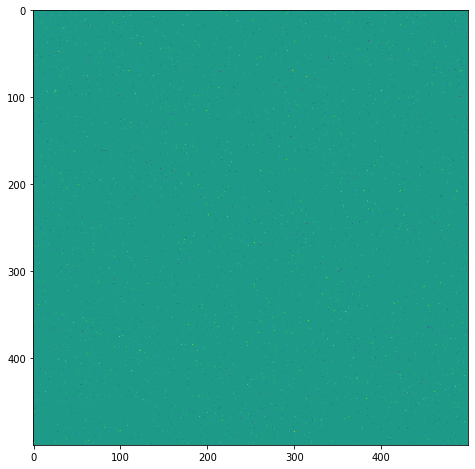

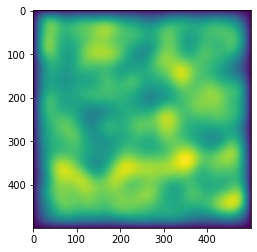

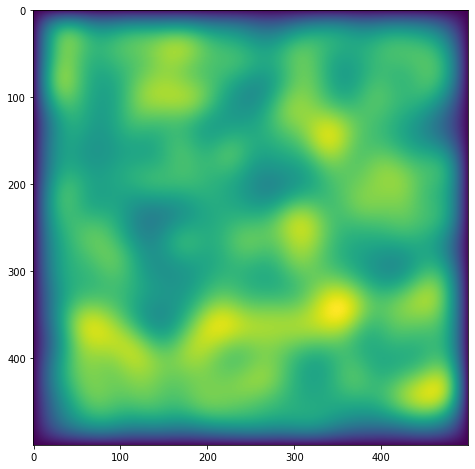

In [3]:
# Play the automaton

nX = 500                 # grid dimension
nY = 500                 # grid dimension
kX = 7                   # kernel dimensions
kY = 7                   # kernel dimensions
nOccupied = 7250         # nuber of initially occupied (1) sites

initial_state = np.zeros((nX, nY))
print('shape of initial_state: ', initial_state.shape)

posX = np.random.randint(0, nX-1, (nOccupied,1))    # randomly generated initial position matrix
posY = np.random.randint(0, nY-1, (nOccupied,1))

posVals = np.expand_dims(np.random.randn(nOccupied), axis=1)

num = 0
for i,j in zip(posX, posY):
        initial_state[i, j] = posVals[num]
        num += 1

plt.figure(figsize=(8,8))
plt.imshow(initial_state)


k = np.ones((kX, kY))

act = 'ReLU'

aut = automaton(initial_state, 120, k, act)     # init_state, num_iter, kernel, activation

aut.evolveAutomaton()    # iterate 100 times or until steady state is reached, whichever comes first!

plt.figure(figsize=(8,8))
plt.imshow(aut.state)

In [4]:
# when a few number of points are initialized at the start and the kernel is small : no interesting patterns
# propagate because of there being no noticeable overlap in the local changes being made